# CS6476 - PS3



## Simon Le Goff

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from math import *
import random 

In [2]:
pts2d_norm_pica=np.loadtxt('pts2d-norm-pic_a.txt')
pts3d_norm=np.loadtxt('pts3d-norm.txt')
pts2d_pica=np.loadtxt('pts2d-pic_a.txt')
pts2d_picb=np.loadtxt('pts2d-pic_b.txt')
pts2d_picb_bad=np.loadtxt('pts2d-pic_b_bad.txt')
pts3d=np.loadtxt('pts3d.txt')



# Part 1 - Calibration 

#### 1.1 Solving M by using the least square method

In [3]:
def least_square_M(pts2d,pts3d):
    nb_pts=pts2d.shape[0]
    A=[]
    B=[]

    for i in range(0,nb_pts):
        X=pts3d[i,0]
        Y=pts3d[i,1]
        Z=pts3d[i,2]
        u=pts2d[i,0]
        v=pts2d[i,1]
        A.append([X,Y,Z,1,0,0,0,0,-u*X,-u*Y,-u*Z])
        A.append([0,0,0,0,X,Y,Z,1,-v*X,-v*Y,-v*Z])
        B.append(u)
        B.append(v)
    
    M,residuals,_,_=np.linalg.lstsq(A,B,rcond=None)
    M=np.append(M,1) #we have to add the last term m23 that we supposed = 1
    M=M.reshape(3,4)
    
    return M,residuals

M,residuals=least_square_M(pts2d_norm_pica,pts3d_norm)
print(M)

[[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]


Lets check if we can get the Mnorm matrix given in the subject from the M matrix found:

In [4]:
0.76785834/-0.4583

-1.6754491381191359

In [5]:
-0.49384797/0.2947

-1.6757650831353919

In [6]:
Mnorm=M/-1.675
print('Mnorm:',Mnorm)
print('Residuals:',residuals)

Mnorm: [[-0.45842289  0.29483461  0.01396884 -0.00402654]
 [ 0.05087367  0.05460787  0.54120795  0.05239211]
 [-0.10904487 -0.17840548  0.04429398 -0.59701493]]
Residuals: [0.00013094]


#### 1.2 - Compute M with different set sizes

In [11]:
def project(pts3d,M):
    nb_pts=np.shape(pts3d)[0]
    pts3d_hom=np.column_stack((pts3d,np.ones((nb_pts,1))))
    #print("project:",np.shape(pts3d_hom))
    pts2d_proj=np.matmul(M,pts3d_hom.T)
    pts2d_proj/=pts2d_proj[2,:]
    return pts2d_proj

def compute_residual(pts2d,pts2d_proj):
    nb_pts=pts2d.shape[0]
    pts2d_hom=np.column_stack((pts2d,np.ones((nb_pts,1))))
    residual=np.sum(np.sqrt((pts2d_hom.T-pts2d_proj)**2))
    
    return residual

In [19]:
k=[8,12,16]

#setsize=k
nb_pts=pts2d_picb.shape[0]

#intialize state of the RNG 
random.seed()

ind=[i for i in range(nb_pts)]
residual_tab=[]    
residual_min=100
M_best=[]
for k in k: 
    for i in range(10):
        ind_sampled=random.sample(ind,k)
        pts2d_sampled=pts2d_picb[ind_sampled]
        pts3d_sampled=pts3d[ind_sampled]
    
        M,res=least_square_M(pts2d_sampled,pts3d_sampled)
        #print('Residual function:',res)
        ind_left=[i for i in ind if i not in ind_sampled]
        ind_residual=random.sample(ind_left,4)
        pts2d_proj=project(pts3d[ind_residual],M)
        residual=compute_residual(pts2d_picb[ind_residual],pts2d_proj)
        m_residual=residual/4
        if m_residual<residual_min: 
            residual_min=m_residual
            M_best=M
    
        residual_tab.append(m_residual)

residual_tab=np.asarray(residual_tab).reshape(30,1)       
res_8=sum(residual_tab[i] for i in range(10))/10 
res_12=sum(residual_tab[i] for i in range(10,20))/10
res_16=sum(residual_tab[i] for i in range(20,30))/10


#print('Tab of residual: ',residual_tab)
print('Best M: ',M)    

print('res_8: ', res_8)
print('res_12: ',res_12)
print('res_16: ',res_16)


Best M:  [[-2.04245679e+00  1.17771834e+00  4.03228374e-01  2.45052896e+02]
 [-4.55679228e-01 -3.06264252e-01  2.15407208e+00  1.66684713e+02]
 [-2.24143765e-03 -1.10032164e-03  5.72083277e-04  1.00000000e+00]]
res_8:  [4.17553166]
res_12:  [2.12670755]
res_16:  [1.6075447]


Here we wanted to the difference of computing M with different setsizes of points instead selected from the initial set of 20 points. We measure the residual between the projection of a 3D world point in the image and the actual position of the point in the set given. As we can see, the shorter the size set is and the bigger the residual is, which is normal because when we try to compute M with less points we increase the error of prediction. Having more points than unknown for M adds some redundacy which improves the results.

#### 1.3 Given the best M form last part, compute C the position of the camera center

In [9]:
def compute_C(M):
    Q=M[0:3,0:3]
    m4=M[:,3]
    C=np.matmul(-np.linalg.inv(Q),m4)
    return C

Cnorm=compute_C(Mnorm)
print(Cnorm)

[-1.51263977 -2.35165965  0.28266502]


We got the same C given in the subject for Mnorma so the function compute_C is working.

In [10]:
C=compute_C(M_best)
print('C:',C)

C: [303.08466492 307.17981248  30.42126103]


## Part 2 - Fundamental Matrix Estimation 

#### 2.1 - Determine $\tilde{F}$ using least squares

In [56]:
def least_square_Ftil(pts2d_pica,pts2d_picb):
    nb_pts=pts2d_pica.shape[0]
    A=[]
    B=[]
    
    for i in range(0,nb_pts):
        up=pts2d_picb[i,0]
        vp=pts2d_picb[i,1]
        u=pts2d_pica[i,0]
        v=pts2d_pica[i,1]
        A.append([up*u,up*v,up,vp*u,vp*v,vp,u,v])
        B.append(-1)
        
    Ftil,residuals,_,_=np.linalg.lstsq(A,B,rcond=None)
    Ftil=np.append(Ftil,1) #we have to add the last term f22 that we supposed = 1
    Ftil=Ftil.reshape(3,3)
    
    return Ftil,residuals

Ftil,residuals=least_square_Ftil(pts2d_pica,pts2d_picb)
print(Ftil)

[[-6.60675944e-07  7.90642197e-06 -1.88480992e-03]
 [ 8.82674944e-06  1.21863596e-06  1.72276843e-02]
 [-9.08539064e-04 -2.64201801e-02  1.00000000e+00]]


#### 2.2 Use SVD to reduce the rank of $\tilde{F}$ and get F

In [57]:
def svd_F(Ftil):
    u,s,vh=np.linalg.svd(Ftil)
    last_ind=s.shape[0]-1
    s[last_ind]=0
    sizeF=np.shape(Ftil)[0]
    F=np.linalg.multi_dot([u,np.identity(sizeF)*s,vh])
    
    return F
F=svd_F(Ftil)
print(F)

[[-5.35883058e-07  7.89972529e-06 -1.88480998e-03]
 [ 8.83820595e-06  1.21802118e-06  1.72276843e-02]
 [-9.08539027e-04 -2.64201801e-02  1.00000000e+00]]


#### 2.3 - Estimate the epipolar lines

In [26]:
pic_a=cv2.imread('pic_a.jpg')
pic_b=cv2.imread('pic_b.jpg')

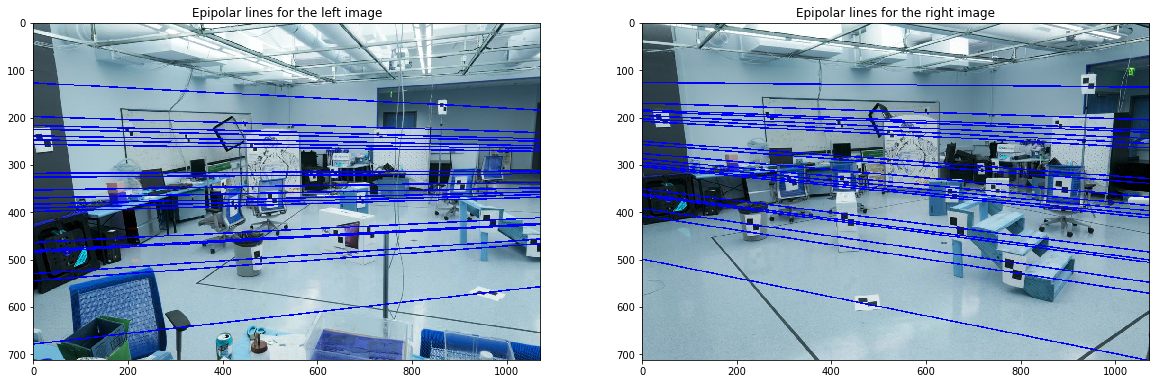

In [25]:
def draw_epipolar(left_im,right_im,pts_left,pts_right,F):
    #need to copy the image first because cv2.line changes the images
    lim_copy=left_im.copy()
    rim_copy=right_im.copy()
    
    ###########################
    #### Draw on the left image first
    #################################
    lim_r,lim_c,_=left_im.shape
    Pul=[0,0,1]
    Pbl=[lim_r-1,0,1]
    Pur=[0,lim_c-1,1]
    Pbr=[lim_r-1,lim_c-1,1]
    
    #lines of the side of the image
    lL=np.cross(Pul,Pbl)
    lR=np.cross(Pur,Pbr)

    pts_left_hom=np.column_stack((pts_left,np.ones((pts_left.shape[0],1))))
    pts_right_hom=np.column_stack((pts_right,np.ones((pts_right.shape[0],1))))
    
    for i in range(pts_left.shape[0]):
        #project every points of the right image to get the line in the left image
        li=np.matmul(F,pts_right_hom[i])
        PiL=np.cross(li,lL)
        PiL/=PiL[2]
        PiR=np.cross(li,lR)
        PiR/=PiR[2]

        PiL=PiL.astype(int)
        PiR=PiR.astype(int)
        lim_copy=cv2.line(lim_copy, (PiL[0],PiL[1]), (PiR[0],PiR[1]), (0,0,255), 2)
    
    #####################
    ### Draw on the right image 
    ####################
    for i in range(pts_right.shape[0]):
        #careful, take F.T and not F for this one 
        li=np.matmul(F.T,pts_left_hom[i])
        PiL=np.cross(li,lL)
        PiL/=PiL[2]
        PiR=np.cross(li,lR)
        PiR/=PiR[2]

        PiL=PiL.astype(int)
        PiR=PiR.astype(int)
        rim_copy=cv2.line(rim_copy, (PiL[0],PiL[1]), (PiR[0],PiR[1]), (0,0,255), 2)
    
    fig=plt.figure(figsize=(20,20))
    #plt.figure(figsize=(20,20))
    epL=plt.subplot(121)
    epL.title.set_text("Epipolar lines for the left image")
    plt.imshow(lim_copy)
    epR=plt.subplot(122)
    epR.title.set_text("Epipolar lines for the right image")
    plt.imshow(rim_copy)

    
draw_epipolar(pic_b,pic_a,pts2d_picb,pts2d_pica,F)


    
    
    
    
    

#### Extra credit

In [65]:
#Here we use the sets pts2d_pica and pts2d_picb

cu_a=np.mean(pts2d_pica[:,0])
cv_a=np.mean(pts2d_pica[:,1])

cu_b=np.mean(pts2d_picb[:,0])
cv_b=np.mean(pts2d_picb[:,1])

m_a=[cu_a*np.ones((pts2d_pica.shape[0],1)),cv_a*np.ones((pts2d_pica.shape[0],1))]
s_a=np.std(pts2d_pica-m_a)

m_b=[cu_b*np.ones((pts2d_picb.shape[0],1)),cv_b*np.ones((pts2d_picb.shape[0],1))]
s_b=np.std(pts2d_picb-m_b)

T_a=np.asarray([[s_a,0,-cu_a*s_a],[0,s_a,-cv_a*s_a],[0,0,1]])
T_b=np.asarray([[s_b,0,-cu_b*s_b],[0,s_b,-cv_b*s_b],[0,0,1]])

pts2d_pica_hom=np.column_stack((pts2d_pica,np.ones((pts2d_pica.shape[0],1))))
new_pts_a=np.matmul(T_a,pts2d_pica_hom.T)

pts2d_picb_hom=np.column_stack((pts2d_picb,np.ones((pts2d_picb.shape[0],1))))
new_pts_b=np.matmul(T_a,pts2d_picb_hom.T)


In [81]:
new_F_til=least_square_Ftil(new_pts_a.T,new_pts_b.T)
print(new_F_til)
print(np.linalg.matrix_rank(new_F_til))
#new_svd_F=svd_F(new_F_til)

(array([[ 1.69337260e-11, -2.62417575e-10, -2.26604106e-06],
       [-1.78680899e-10,  4.58657431e-11, -1.52122986e-04],
       [-1.10133493e-05,  1.46842806e-04,  1.00000000e+00]]), array([0.01280257]))
1


I can't apply my function to get obtain the new F because my new $\tilde{F}$ has a rank of 1, but I don't know what went wrong when I computed the normalized points. If you have any clue 